In [1]:
import numpy as np
import pandas as pd
import glob
import statsmodels.api as sm

## Behavioral analysis

In [13]:
def select_dep(x):
    unav_action = x['unavAct']
    if x['trType']==2:
        if unav_action==2:
            if x['choice']<unav_action:
                return 1
            else:
                return 0
        elif unav_action==3:
            if x['choice']==1:
                return 1
            else:
                return 0
        else:
            if x['choice']==2:
                return 1
            else:
                return 0
    
def left_most(x):
    observed_action = x['corrAct']
    hidden_action = x['unavAct']
    if observed_action ==1:
        return 1
    elif hidden_action==1:
        return 0
    elif observed_action!=1:
        return -1
    
    
        

In [14]:
df_dirs = glob.glob("data\study1\*.xlsx")
action_beta = []
token_beta = []
for dir in df_dirs:
    df =pd.read_excel(dir)
    df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
    df['dependent'] = df.apply(lambda row: select_dep(row), axis=1)
    df['switches'] = df['goalToken'].diff()
    df['left_most'] = df.apply(lambda row: left_most(row), axis=1)
    switch_indexes = df[(df.switches!=0) & (~ df.switches.isna())].index
    df['past_action_score'] = 0
    cum_sum =0 
    for i in range(df.shape[0]):
        if i in switch_indexes:
            cum_sum=0
        else:
            cum_sum += df['left_most'][i]
        if df['trType'][i]==2:
            df.loc[i, 'past_action_score'] = cum_sum
                
    df['past_token_score']=0
    color_map= [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
    prob_sum = 0
    for i in range(df.shape[0]):
        if i in switch_indexes:
            prob_sum=0
        else:
            hidden_action = df['unavAct'][i]
            left = 2 if hidden_action==1 else 1
            right = 2 if hidden_action==3 else 3
            shown_token = df['tokenShown'][i]
            
            p_left_shown_token = df[color_map[left-1][str(int(shown_token)-1)]][i]
            p_right_shown_token = df[color_map[right-1][str(int(shown_token)-1)]][i]
            
            prob_sum += (p_left_shown_token - p_right_shown_token)
        
        if df['trType'][i]==2:
            df.loc[i, 'past_token_score'] = prob_sum
            
    Binomial_model = sm.GLM(df[df.trType==2].dependent, df[df.trType==2].past_action_score, family=sm.families.Binomial())
    Binomial_results = Binomial_model.fit()
    action_beta.append(Binomial_results.params['past_action_score'])
    
    Binomial_model = sm.GLM(df[df.trType==2].dependent, df[df.trType==2].past_token_score, family=sm.families.Binomial())
    Binomial_results = Binomial_model.fit()
    token_beta.append(Binomial_results.params['past_token_score']) 

        
    
    
    
    


<AxesSubplot:xlabel='labels', ylabel='betas'>

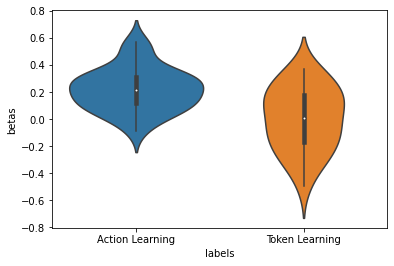

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
action_label = ['Action Learning' for i in range(len(action_beta))]
token_label = ['Token Learning' for i in range(len(token_beta))]

final_list = action_beta + token_beta
final_label = action_label + token_label

data = pd.DataFrame({'betas':final_list,
                     'labels':final_label})
sns.violinplot(x="labels", y="betas", data=data)



In [16]:
from mlxtend.evaluate import permutation_test

p_value = permutation_test(action_beta, token_beta,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)

0.00019998000199980003


In [67]:
print(Binomial_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dependent   No. Observations:                   80
Model:                            GLM   Df Residuals:                       79
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -55.418
Date:                Mon, 20 Jun 2022   Deviance:                       110.84
Time:                        19:38:41   Pearson chi2:                     80.0
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
past_token_score    -0.0494      0.192  

## Emulation Inference

In [17]:
df_dirs = glob.glob("data\study1\*.xlsx")
df = pd.read_excel(df_dirs[0])
df.head()

,index,trialNb,runPos,runNb,trType,goalToken,tvCond,buCond,unavAct,corrAct,...,pBlue,pGoal,randn,isGoal,tokenShown,token_onset,outcome,fixation_iti_onset,miss,missed_onset
0,0,1,1,4,1,1,1,2,1,3,...,0.5,0.3,0.880821,0.0,2.0,9.033105,0,10.034542,0,NaN
1,1,2,1,4,1,1,1,2,3,1,...,0.2,0.5,0.190481,1.0,1.0,25.010186,0,26.006287,0,NaN
2,2,3,1,4,1,1,1,2,2,1,...,0.2,0.5,0.714558,0.0,2.0,39.022731,0,40.022561,0,NaN
3,3,4,1,4,2,1,1,2,1,3,...,0.5,0.3,0.135449,0.0,3.0,51.579524,0,52.579051,0,NaN
4,4,5,1,4,1,1,1,2,2,1,...,0.2,0.5,0.452964,1.0,1.0,65.557423,0,66.562102,0,NaN


In [7]:
df.columns

Index(['index', 'trialNb', 'runPos', 'runNb', 'trType', 'goalToken', 'tvCond',
       'buCond', 'unavAct', 'corrAct', 'bestAct', 'vertOrd', 'horizOrd',
       'obsplay_onset', 'sm_onset', 'fixation1_onset', 'choose_onset',
       'choice', 'choiceRT', 'isCorr', 'resp_onset', 'ch_fb_onset',
       'video_onset', 'video_nb', 'fixation2_onset', 'pGreen', 'pRed', 'pBlue',
       'pGoal', 'randn', 'isGoal', 'tokenShown', 'token_onset', 'outcome',
       'fixation_iti_onset', 'miss', 'missed_onset'],
      dtype='object')

In [18]:
import random
random.shuffle(df_dirs)

In [23]:
color_map = [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
color_values = {'green':1/3, 'blue':1/3, 'red':1/3}
machine_values = [0, 0 , 0]
gamma = 0.99
df = pd.read_excel(df_dirs[0])
df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
observable_trials = df[df.trType==1].reset_index(drop=True)
for i in range(observable_trials.shape[0]):
    hidden_action = observable_trials['unavAct'][i]
    left = 2 if hidden_action==1 else 1
    right = 2 if hidden_action==3 else 3
    shown_token = observable_trials['tokenShown'][i]
    selected_machine = observable_trials['corrAct'][i]
    
    p_prior_green = gamma * color_values['green'] + (1-gamma) * (color_values['blue'] + color_values['red'])/2
    p_prior_red = gamma * color_values['red'] + (1-gamma) * (color_values['blue'] + color_values['green'])/2
    p_prior_blue = gamma * color_values['blue'] + (1-gamma) * (color_values['green'] + color_values['red'])/2

    p_evidence_green = 1 if (int(shown_token)-1) ==2 else 0
    color_values['green'] = p_prior_green * p_evidence_green
    
    p_evidence_red = 1 if (int(shown_token)-1) ==1 else 0
    color_values['red'] = p_prior_red * p_evidence_red
    
    p_evidence_blue = 1 if (int(shown_token)-1) ==0 else 0
    color_values['blue'] = p_prior_blue * p_evidence_blue

    machine_values[0] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
    machine_values[1] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
    machine_values[2] =  observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']


In [25]:
color_map = [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
color_values = {'green':1/3, 'blue':1/3, 'red':1/3}
machine_values = [0, 0 , 0]
gamma = 0.99
for dir in df_dirs[:-5]:
    df = pd.read_excel(dir)
    df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
    observable_trials = df[df.trType==1].reset_index(drop=True)
    for i in range(observable_trials.shape[0]):
        hidden_action = observable_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        shown_token = observable_trials['tokenShown'][i]
        selected_machine = observable_trials['corrAct'][i]
        
        p_prior_green = gamma * color_values['green'] + (1-gamma) * (color_values['blue'] + color_values['red'])/2
        p_prior_red = gamma * color_values['red'] + (1-gamma) * (color_values['blue'] + color_values['green'])/2
        p_prior_blue = gamma * color_values['blue'] + (1-gamma) * (color_values['green'] + color_values['red'])/2
        
        p_evidence_green = 1 if (int(shown_token)-1) ==2 else 0
        color_values['green'] = p_prior_green * p_evidence_green
        
        p_evidence_red = 1 if (int(shown_token)-1) ==1 else 0
        color_values['red'] = p_prior_red * p_evidence_red
        
        p_evidence_blue = 1 if (int(shown_token)-1) ==0 else 0
        color_values['blue'] = p_prior_blue * p_evidence_blue

        machine_values[0] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values[1] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values[2] =  observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']

predicted_action = []
selected_action = []
beta = 0.5
for dir in df_dirs[-5:]:     
    df = pd.read_excel(dir)  
    play_trials = df[df.trType==2].dropna(subset=['choice']).reset_index(drop=True)
    for i in range(play_trials.shape[0]):
        hidden_action = play_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        
        p_left = 1/(1+ np.exp(-beta *(machine_values[left-1] - machine_values[right-1])))
        p_right = 1- p_left
        
        predicted_action.append(np.random.choice([left,right], p=[p_left, p_right]))
        selected_action.append(int(play_trials['choice'][i]))
    
           



In [28]:
count = 0
for i in range(len(predicted_action)):
    if predicted_action[i]==selected_action[i]:
        count+=1
    
count/len(predicted_action)

0.49624060150375937

# Imitation RL

In [31]:
color_map = [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
color_values = {'green':1/3, 'blue':1/3, 'red':1/3}
machine_values = [0, 0 , 0]
alpha = 0.6
for dir in df_dirs[:-5]:
    df = pd.read_excel(dir)
    df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
    observable_trials = df[df.trType==1].reset_index(drop=True)
    for i in range(observable_trials.shape[0]):
        selected_machine = observable_trials['corrAct'][i]
        machines = [0,1,2]
        machines.remove(selected_machine-1)
        machine_values[selected_machine-1] = machine_values[selected_machine-1] + alpha * (1- machine_values[selected_machine-1])
        for m in range(len(machines)):
            machine_values[m] = machine_values[m] +alpha * (-1-machine_values[m])
       
predicted_action = []
selected_action = []
beta = 0.5
for dir in df_dirs[-5:]:     
    df = pd.read_excel(dir)  
    play_trials = df[df.trType==2].dropna(subset=['choice']).reset_index(drop=True)
    for i in range(play_trials.shape[0]):
        hidden_action = play_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        
        p_left = 1/(1+ np.exp(-beta *(machine_values[left-1] - machine_values[right-1])))
        p_right = 1- p_left
        
        predicted_action.append(np.random.choice([left,right], p=[p_left, p_right]))
        selected_action.append(int(play_trials['choice'][i]))
    
           



In [32]:
count = 0
for i in range(len(predicted_action)):
    if predicted_action[i]==selected_action[i]:
        count+=1
    
count/len(predicted_action)

0.5137844611528822

In [34]:
color_map = [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
color_values = {'green':1/3, 'blue':1/3, 'red':1/3}
machine_values = [0, 0 , 0]
alpha = 0.5
etta = 0.0001
for dir in df_dirs[:-5]:
    df = pd.read_excel(dir)
    df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
    observable_trials = df[df.trType==1].reset_index(drop=True)
    for i in range(observable_trials.shape[0]):
        selected_machine = observable_trials['corrAct'][i]
        machines = [0,1,2]
        machines.remove(selected_machine-1)
        alpha = etta * np.abs(1 - machine_values[selected_machine-1])  + (1-etta)*alpha
        machine_values[selected_machine-1] = machine_values[selected_machine-1] + alpha * (1- machine_values[selected_machine-1])
        for m in range(len(machines)):
            machine_values[m] = machine_values[m] +alpha * (-1-machine_values[m])
       
predicted_action = []
selected_action = []
beta = 0.5
for dir in df_dirs[-5:]:     
    df = pd.read_excel(dir)  
    play_trials = df[df.trType==2].dropna(subset=['choice']).reset_index(drop=True)
    for i in range(play_trials.shape[0]):
        hidden_action = play_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        
        p_left = 1/(1+ np.exp(-beta *(machine_values[left-1] - machine_values[right-1])))
        p_right = 1- p_left
        
        predicted_action.append(np.random.choice([left,right], p=[p_left, p_right]))
        selected_action.append(int(play_trials['choice'][i]))
    
           



In [35]:
count = 0
for i in range(len(predicted_action)):
    if predicted_action[i]==selected_action[i]:
        count+=1
    
count/len(predicted_action)

0.5388471177944862

# Emulation RL

In [38]:
color_map = [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
color_values = {'green':0, 'blue':0, 'red':0}
machine_values = [0, 0 , 0]
alpha = 0.3
for dir in df_dirs[:-5]:
    df = pd.read_excel(dir)
    df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
    observable_trials = df[df.trType==1].reset_index(drop=True)
    for i in range(observable_trials.shape[0]):
        hidden_action = observable_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        shown_token = observable_trials['tokenShown'][i]
        selected_machine = observable_trials['corrAct'][i]
        
        tpe_green = 1-color_values['green'] if (int(shown_token)-1) ==2 else -1-color_values['green']
        color_values['green'] = color_values['green'] + alpha * tpe_green
        
        tpe_red = 1-color_values['red'] if (int(shown_token)-1) ==1 else -1-color_values['red']
        color_values['red'] = color_values['red'] + alpha * tpe_red
        
        tpe_blue = -1-color_values['blue'] if (int(shown_token)-1) ==0 else -1-color_values['blue']
        color_values['blue'] = color_values['blue'] + alpha * tpe_blue

        machine_values[0] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values[1] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values[2] =  observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']

predicted_action = []
selected_action = []
beta = 0.5
for dir in df_dirs[-5:]:     
    df = pd.read_excel(dir)  
    play_trials = df[df.trType==2].dropna(subset=['choice']).reset_index(drop=True)
    for i in range(play_trials.shape[0]):
        hidden_action = play_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        
        p_left = 1/(1+ np.exp(-beta *(machine_values[left-1] - machine_values[right-1])))
        p_right = 1- p_left
        
        predicted_action.append(np.random.choice([left,right], p=[p_left, p_right]))
        selected_action.append(int(play_trials['choice'][i]))
    
           



In [39]:
count = 0
for i in range(len(predicted_action)):
    if predicted_action[i]==selected_action[i]:
        count+=1
    
count/len(predicted_action)

0.5213032581453634

In [42]:
color_map = [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
color_values = {'green':0, 'blue':0, 'red':0}
machine_values = [0, 0 , 0]
alpha = 0.3
for dir in df_dirs[:-5]:
    df = pd.read_excel(dir)
    df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
    observable_trials = df[df.trType==1].reset_index(drop=True)
    for i in range(observable_trials.shape[0]):
        hidden_action = observable_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        shown_token = observable_trials['tokenShown'][i]
        selected_machine = observable_trials['corrAct'][i]
        
        alpha = etta * np.abs(1 - machine_values[selected_machine-1])  + (1-etta)*alpha
        
        tpe_green = 1-color_values['green'] if (int(shown_token)-1) ==2 else -1-color_values['green']
        color_values['green'] = color_values['green'] + alpha * tpe_green
        
        tpe_red = 1-color_values['red'] if (int(shown_token)-1) ==1 else -1-color_values['red']
        color_values['red'] = color_values['red'] + alpha * tpe_red
        
        tpe_blue = -1-color_values['blue'] if (int(shown_token)-1) ==0 else -1-color_values['blue']
        color_values['blue'] = color_values['blue'] + alpha * tpe_blue

        machine_values[0] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values[1] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values[2] =  observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']

predicted_action = []
selected_action = []
beta = 0.5
for dir in df_dirs[-5:]:     
    df = pd.read_excel(dir)  
    play_trials = df[df.trType==2].dropna(subset=['choice']).reset_index(drop=True)
    for i in range(play_trials.shape[0]):
        hidden_action = play_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        
        p_left = 1/(1+ np.exp(-beta *(machine_values[left-1] - machine_values[right-1])))
        p_right = 1- p_left
        
        predicted_action.append(np.random.choice([left,right], p=[p_left, p_right]))
        selected_action.append(int(play_trials['choice'][i]))
    
           



In [43]:
count = 0
for i in range(len(predicted_action)):
    if predicted_action[i]==selected_action[i]:
        count+=1
    
count/len(predicted_action)

0.5263157894736842

# Arbitration

In [44]:
color_map = [{'0':'pBlue', '1':'pRed','2':'pGreen'}, {'0':'pGreen', '1':'pBlue','2':'pRed'}, {'0':'pRed', '1':'pGreen','2':'pBlue'}]
color_values = {'green':1/3, 'blue':1/3, 'red':1/3}
machine_values_emulation = [0, 0 , 0]
machine_values_imitation = [0, 0 , 0]

gamma = 0.99
delta = 0.05
alpha = 0.05
ape = 0.1
entropy = 1
for dir in df_dirs[:-5]:
    df = pd.read_excel(dir)
    df= df.dropna(subset=['tokenShown']).reset_index(drop=True)
    observable_trials = df[df.trType==1].reset_index(drop=True)
    for i in range(observable_trials.shape[0]):
        hidden_action = observable_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        shown_token = observable_trials['tokenShown'][i]
        selected_machine = observable_trials['corrAct'][i]
        
        p_prior_green = gamma * color_values['green'] + (1-gamma) * (color_values['blue'] + color_values['red'])/2
        p_prior_red = gamma * color_values['red'] + (1-gamma) * (color_values['blue'] + color_values['green'])/2
        p_prior_blue = gamma * color_values['blue'] + (1-gamma) * (color_values['green'] + color_values['red'])/2
        
        p_evidence_green = 1 if (int(shown_token)-1) ==2 else 0
        color_values['green'] = p_prior_green * p_evidence_green
        
        p_evidence_red = 1 if (int(shown_token)-1) ==1 else 0
        color_values['red'] = p_prior_red * p_evidence_red
        
        p_evidence_blue = 1 if (int(shown_token)-1) ==0 else 0
        color_values['blue'] = p_prior_blue * p_evidence_blue

        machine_values_emulation[0] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values_emulation[1] = observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']
        machine_values_emulation[2] =  observable_trials[color_map[0]['0']][i] * color_values['blue'] + observable_trials[color_map[0]['1']][i] * color_values['red'] +observable_trials[color_map[0]['2']][i] * color_values['green']

        machines = [0,1,2]
        machines.remove(selected_machine-1)
        machine_values_imitation[selected_machine-1] = machine_values_imitation[selected_machine-1] + alpha * (1- machine_values_imitation[selected_machine-1])
        for m in range(len(machines)):
            machine_values_imitation[m] = machine_values_imitation[m] +alpha * (-1-machine_values_imitation[m])
        
        
        
        
        
predicted_action = []
selected_action = []
beta = 0.5
for dir in df_dirs[-5:]:     
    df = pd.read_excel(dir)  
    play_trials = df[df.trType==2].dropna(subset=['choice']).reset_index(drop=True)
    for i in range(play_trials.shape[0]):
        hidden_action = play_trials['unavAct'][i]
        left = 2 if hidden_action==1 else 1
        right = 2 if hidden_action==3 else 3
        
        prev_entropy = entropy 
        entropy = -1 * np.sum(np.array(machine_values_emulation) * np.log2(np.array(machine_values_emulation)+0.001))
        
        R_em = 1 - (entropy - 0)/(10 - 0)
        
        ape = np.abs(1 - machine_values_imitation[selected_machine-1])
        
        prev_ape = np.abs(ape)
        
        R_im =  1 - (ape - 0)/(10 -0)
        
        omega = 1/(1+np.exp(-(R_em - R_im + delta)))
        
        p_em_left = 1/(1+ np.exp(-beta *(machine_values_emulation[left-1] - machine_values_emulation[right-1])))
        p_im_left = 1/(1+ np.exp(-beta *(machine_values_imitation[left-1] - machine_values_imitation[right-1])))
        p_left = omega*p_em_left + (1-omega)*p_im_left
        
        p_right = 1- p_left
        
        predicted_action.append(np.random.choice([left,right], p=[p_left, p_right]))
        selected_action.append(int(play_trials['choice'][i]))
    
           



In [45]:
count = 0
for i in range(len(predicted_action)):
    if predicted_action[i]==selected_action[i]:
        count+=1
    
count/len(predicted_action)

0.5463659147869674